# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 2

Please use the following code to prepare the dataset.
 

In [99]:
from folktables.acs import adult_filter
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import pandas as pd

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)


def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', 'RAC1P'],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)

# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm' ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)
        
features.head()

Columns with the protected features:
Column ID: 54 (SEX_Female)
Column ID: 55 (RAC1P_Black or African American alone)


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,21.0,20.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,65.0,8.0,33.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33.0,40.0,53.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18.0,18.0,106.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,27.0,50.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:

sex_index = features.columns.tolist().index('SEX_Female')
print(sex_index)
race_index = features.columns.tolist().index('RAC1P_Black or African American alone')
print(race_index)

54
55


In [101]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(features, labels, groups, test_size=0.1, random_state=0)


In [102]:
#######
# YOUR CODE
#######
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
#groups
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef



scoring = {'accuracy': make_scorer(accuracy_score),            
           'prec': 'precision'}

numeric_features = ["AGEP","WKHP", "PWGTP"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(X_train,y_train.values.ravel())

cv = KFold(n_splits=(100))
score_list = ["accuracy", "f1", "matthews_corrcoef"]
score_dict= {}
for score in score_list: 

    scores = cross_val_score(clf, X_test, y_test.values.ravel(), cv = cv,scoring=score)
    score_dict[score] = scores
#print(score_dict["accuracy"])

In [103]:
print(score_dict["matthews_corrcoef"])

[0.68364559 0.63075775 0.58388675 0.49143539 0.4284804  0.61429532
 0.48408894 0.48835438 0.51813696 0.60208562 0.52739044 0.43196398
 0.5179324  0.39361303 0.42279893 0.58109107 0.47599154 0.55512249
 0.49979563 0.57682089 0.50479904 0.61919238 0.53306768 0.40287968
 0.39713632 0.5        0.52830196 0.50735932 0.51831885 0.55045351
 0.40342273 0.57123426 0.48737732 0.53306768 0.48507125 0.55477698
 0.58730159 0.62945817 0.55833159 0.48786004 0.60038092 0.44559522
 0.54141433 0.53380123 0.65876905 0.40468503 0.49178299 0.74038021
 0.45954297 0.43828469 0.38262677 0.50207901 0.61386192 0.49426553
 0.52048004 0.50150299 0.52457467 0.56591646 0.50021498 0.54748571
 0.54935027 0.53122757 0.61029094 0.46483484 0.49121832 0.56605262
 0.47904681 0.52603387 0.5074666  0.58400279 0.32465542 0.49878224
 0.35423459 0.40089186 0.68825552 0.52148584 0.42395113 0.477256
 0.57691565 0.51299774 0.4859123  0.53843934 0.69060949 0.48750011
 0.60646844 0.65558442 0.45374657 0.52025243 0.45582911 0.468547

In [104]:

### Get Females, Males, Blacks and whites 
### Should we further subdevide them??

female = X_test.loc[X_test["SEX_Female"] == 1.0]
male = X_test.loc[X_test["SEX_Female"] == 0.0]
blacks = X_test.loc[X_test["RAC1P_Black or African American alone"] == 1.0]
whites = X_test.loc[X_test["RAC1P_Black or African American alone"] == 0.0]

[]

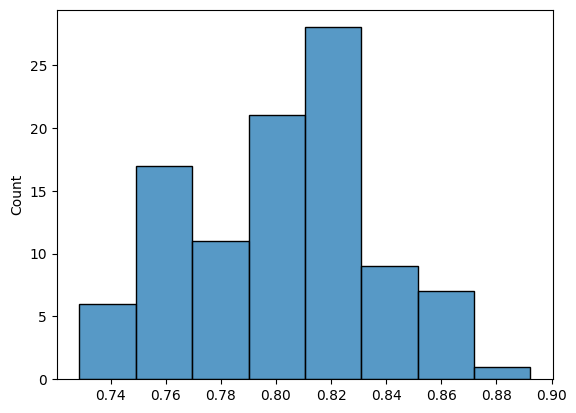

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(score_dict["accuracy"])
plt.plot()

In [106]:
X_test.loc[groups_test[groups_test["SEX"] == 2].index.tolist()]

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
72476,63.0,50.0,99.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
25524,36.0,30.0,67.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
57955,32.0,40.0,66.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
119330,25.0,40.0,250.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6278,54.0,45.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62379,48.0,40.0,61.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2967,21.0,30.0,99.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
57657,65.0,60.0,141.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
60385,27.0,40.0,67.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [107]:
groups_test.loc[groups_test["SEX"]==1]["SEX"].values
print(set(groups_test["RAC1P"].values))
#groups_test["SEX" == 1]

{1, 2}


In [108]:
### score when split the dataset 
### Look at different scores
import matplotlib.pyplot as plt


score_dict_sex = {}
score_dict_race = {}
score_list = ["accuracy", "f1", "matthews_corrcoef"]
for i in range(1,3):
    score_dict_sex[i] = {}
    score_dict_race[i] = {}
    for score in score_list: 
        print(i)
        score_sex = cross_val_score(clf, X_test.loc[groups_test[groups_test["SEX"] == i].index.tolist()], 
                                    y_test.loc[groups_test[groups_test["SEX"] == i].index.tolist()].values.ravel(), 
                                    cv = cv, scoring = score)
        score_race = cross_val_score(clf, X_test.loc[groups_test[groups_test["RAC1P"] == i].index.tolist()], 
                                    y_test.loc[groups_test[groups_test["RAC1P"] == i].index.tolist()].values.ravel(), 
                                    cv = cv)
        score_dict_sex[i][score] = score_sex
        score_dict_race[i][score] = score_race

#print(score_dict_sex)
#print(score_dict_race)        

        


1
1
1
2
2
2


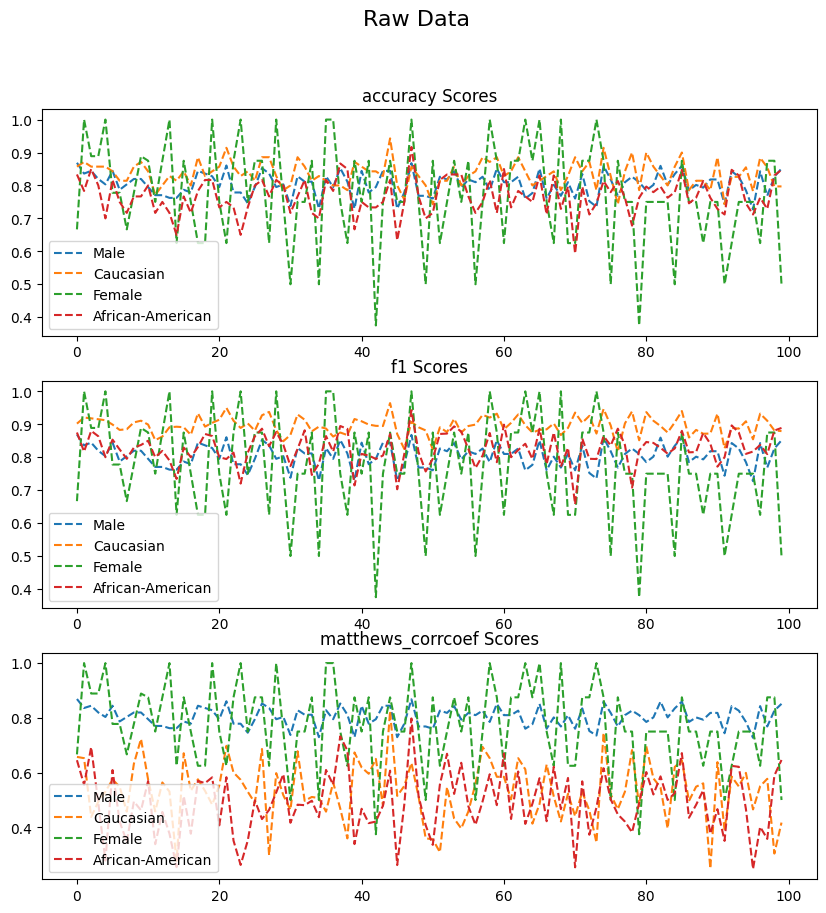

In [109]:

f, axes = plt.subplots(3,1, figsize=(10,10))
                      # # Set a title for the entire figure
f.suptitle("Raw Data", fontsize=16)
for count, metric in enumerate(score_list):
    for i in range(1,3):
        if i == 1: 
            axes[count].plot(score_dict_race[i][metric], linestyle = "--", label = "Male")
            axes[count].plot(score_dict_sex[i][metric], linestyle = "--", label = "Caucasian")
            
        else: 
            axes[count].plot(score_dict_race[i][metric], linestyle = "--", label = "Female")
            axes[count].plot(score_dict_sex[i][metric], linestyle = "--", label = "African-American")
        
        axes[count].set_title(f"{metric} Scores")
        axes[count]
        
        
        
        
        axes[count].legend()

plt.show()


        #plt.title(f"{} Scores")


1
2


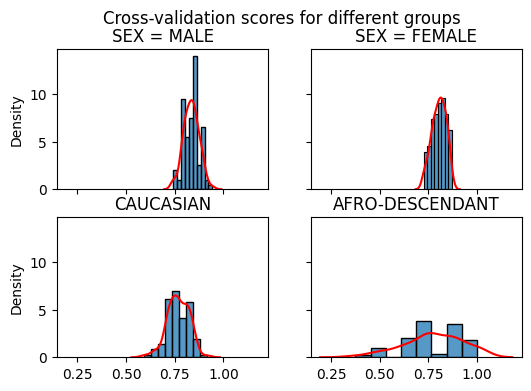

In [12]:
# score when split the dataset
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2,2, figsize=(6,4), sharey=True, sharex=True)

for i in range(1,3):
    print(i)
    score_sex = cross_val_score(clf, X_test.loc[groups_test[groups_test["SEX"] == i].index.tolist()], 
                                y_test.loc[groups_test[groups_test["SEX"] == i].index.tolist()].values.ravel(), 
                                cv = cv)
    score_race = cross_val_score(clf, X_test.loc[groups_test[groups_test["RAC1P"] == i].index.tolist()], 
                                y_test.loc[groups_test[groups_test["RAC1P"] == i].index.tolist()].values.ravel(), 
                                cv = cv)
    
    sns.histplot(score_sex, ax=ax[i-1, 0], kde=False, stat="density", line_kws={"color":"red"})
    sns.kdeplot(score_sex, ax=ax[i-1, 0], color="red")
    sns.histplot(score_race, ax=ax[i-1, 1], kde=False, stat="density", line_kws={"color":"red"})
    sns.kdeplot(score_race, ax=ax[i-1, 1], color="red")

ax[0,0].set_title("SEX = MALE")
ax[0,1].set_title("SEX = FEMALE")


ax[1,0].set_title("CAUCASIAN")
ax[1,1].set_title("AFRO-DESCENDANT")


plt.suptitle("Cross-validation scores for different groups")
plt.show()


In [13]:
### Get Females, Males, Blacks and whites 
### Should we further subdevide them??

female = X_test.loc[X_test["SEX_Female"] == 1.0]
male = X_test.loc[X_test["SEX_Female"] == 0.0]
blacks = X_test.loc[X_test["RAC1P_Black or African American alone"] == 1.0]
whites = X_test.loc[X_test["RAC1P_Black or African American alone"] == 0.0]

#print(list(female.index))

y_index = list(y_test.index)
def find_responding_y_test(data):
    resulting_list = []
    for i in list(data.index):
        if i in y_index:
            resulting_list.append(int(i))
    return resulting_list

f_resulting_index = find_responding_y_test(female)
y_test_female = y_test.loc[f_resulting_index]

m_resulting_index = find_responding_y_test(male)
y_test_male = y_test.loc[m_resulting_index]

b_resulting_index = find_responding_y_test(blacks)
y_test_black = y_test.loc[b_resulting_index]

w_resulting_index = find_responding_y_test(whites)
y_test_white = y_test.loc[w_resulting_index]


In [14]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

In [15]:
#print("Female", clf.score(female, y_test_female))
#print("Male", clf.score(male, y_test_male))
#print("Black", clf.score(blacks, y_test_black))
#print("White", clf.score(whites, y_test_white))

p_f = clf.predict(female)#, y_test_female)
p_m = clf.predict(male)#, y_test_male)
p_b = clf.predict(blacks)#, y_test_black)
p_w = clf.predict(whites)#, y_test_white)


confusion_matrix_female = metrics.confusion_matrix(p_f, y_test_female)
confusion_matrix_male = metrics.confusion_matrix(p_m, y_test_male)
confusion_matrix_whites = metrics.confusion_matrix(p_w, y_test_white)
confusion_matrix_blacks = metrics.confusion_matrix(p_b, y_test_black)

print(confusion_matrix_female )


[[1230  349]
 [1027 3359]]


## Accuracy

In [16]:
print("Accuracy_Score Male: ", round(accuracy_score(y_test_male,p_m ),3))
print("Accuracy_Score Female: ", round(accuracy_score(y_test_female,p_f ),3))
print("Accuracy_Score Whites: ", round(accuracy_score(y_test_white,p_w ),3))
print("Accuracy_Score Blacks: ", round(accuracy_score(y_test_black,p_b ),3))

Accuracy_Score Male:  0.827
Accuracy_Score Female:  0.769
Accuracy_Score Whites:  0.803
Accuracy_Score Blacks:  0.773


## F1 Score

In [17]:
print("F1_Score Male: ", round(f1_score(y_test_male,p_m ),3))
print("F1_Score Female: ", round(f1_score(y_test_female,p_f ),3))
print("F1_Score Whites: ", round(f1_score(y_test_white,p_w ),3))
print("F1_Score Blacks: ", round(f1_score(y_test_black,p_b ),3))

F1_Score Male:  0.891
F1_Score Female:  0.83
F1_Score Whites:  0.867
F1_Score Blacks:  0.835


## Matthews Correlation
-  The Matthews correlation coefficient is more informative than F1 score and accuracy in evaluating binary classification problems, because it takes into account the balance ratios of the four confusion matrix categories (true positives, true negatives, false positives, false negatives)

In [18]:
print("Matthews_corrcoef Male: ", round(matthews_corrcoef(y_test_male,p_m ),5))
print("Matthews_corrcoef Female: ", round(matthews_corrcoef(y_test_female,p_f ),5))
print("Matthews_corrcoef Whites: ", round(matthews_corrcoef(y_test_white,p_w ),5))
print("Matthews_corrcoef Blacks: ", round(matthews_corrcoef(y_test_black,p_b ),5))

Matthews_corrcoef Male:  0.51439
Matthews_corrcoef Female:  0.49561
Matthews_corrcoef Whites:  0.51155
Matthews_corrcoef Blacks:  0.51099


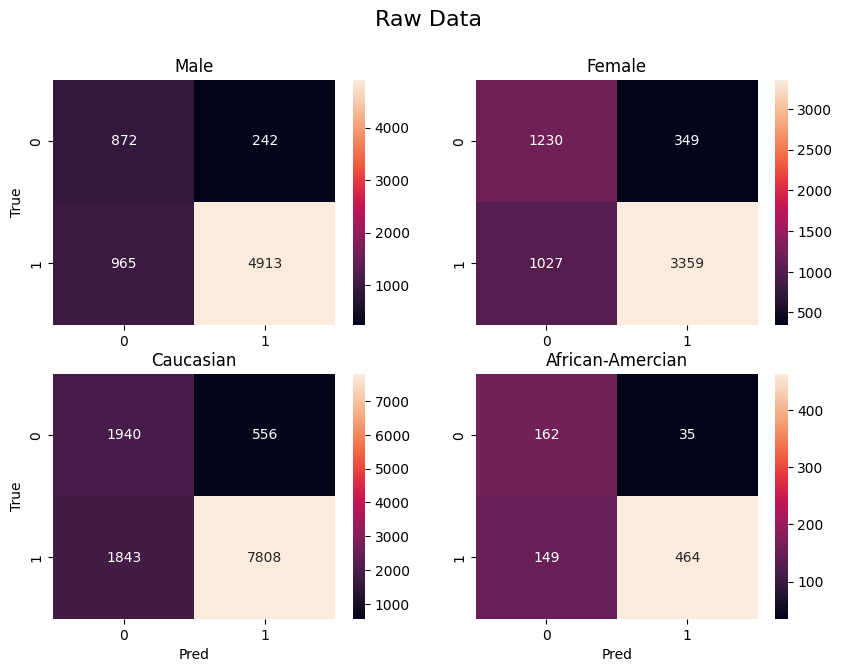

In [110]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(10,7))
# Set a title for the entire figure
fig.suptitle("Raw Data", fontsize=16)
g1= sns.heatmap(confusion_matrix_male, annot=True, fmt='g', ax=ax1[0])
g1.set_ylabel("True")
g1.set_title("Male")
g2= sns.heatmap(confusion_matrix_female, annot=True, fmt='g', ax=ax1[1])
#g1.set_xlabel("True")
g2.set_title("Female")
g3= sns.heatmap(confusion_matrix_whites, annot=True, fmt='g', ax=ax2[0])
g3.set_ylabel("True")
g3.set_xlabel("Pred")
g3.set_title("Caucasian")
g4= sns.heatmap(confusion_matrix_blacks, annot=True, fmt='g', ax=ax2[1])
g4.set_xlabel("Pred")
g4.set_title("African-Amercian")
plt.show()



##  FairPCA

-  Build one classification model using reprojected data from FairPCA. 


In [20]:
X_train.shape
#X_test.shape

(116606, 56)

In [111]:
# Split dataset into train and test sets
#X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
#    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

# Subsample for efficiency
#N = 20000  # Subsample size

# Generate random unique indices for subsampling
#indices_train = np.random.choice(X_train.shape[0], N, replace=False)
#indices_test = np.random.choice(X_test.shape[0], N, replace=False)

# Subsample using the random indices
### Train set
#X_train = X_train.iloc[indices_train]
#y_train = y_train.iloc[indices_train]
#group_train = groups_train.iloc[indices_train]
### Test set
#X_test = X_test.iloc[indices_test]
#y_test = y_test.iloc[indices_test]
#group_test = groups_test.iloc[indices_test]
#group_test_dict = {
#    'Males': group_test['SEX'] == 1,
#   'Females': group_test['SEX'] == 2,
#    'Whites': group_test['RAC1P'] == 1,
#    'African-Americans': group_test['RAC1P'] == 2
#}

# Scale all features (even OHE)
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)
n_features = X_train.shape[1]

# Subset for protected and non-protected features
Xs_train_p = Xs_train[:, 54:]
Xs_test_p = Xs_test[:, 54:]
Xs_train_np = Xs_train[:, :54]
Xs_test_np = Xs_test[:, :54]

In [112]:
scoring = {'accuracy': make_scorer(accuracy_score),            
           'prec': 'precision'}

numeric_features = ["AGEP","WKHP", "PWGTP"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(X_train,y_train.values.ravel())

cv = KFold(n_splits=(100))
score_list = ["accuracy", "f1", "matthews_corrcoef"]
score_dict= {}
for score in score_list: 

    scores = cross_val_score(clf, X_test, y_test.values.ravel(), cv = cv,scoring=score)
    score_dict[score] = scores

In [113]:
X_train.index

Int64Index([ 69171,  86793,  69409,  58700,  34860,  88078,   9708,  43426,
             33018,  52744,
            ...
            122579,  41993,  97639,  95939,  21243,  45891, 117952,  42613,
             43567,  68268],
           dtype='int64', length=116606)

In [114]:
Xs_train_df.iloc[:, :54]

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,SCHL_Grade 4,SCHL_Grade 5,SCHL_Grade 6,SCHL_Grade 7,SCHL_Grade 8,SCHL_Grade 9,SCHL_Kindergarten,SCHL_Master's degree,SCHL_No schooling completed,"SCHL_Nursery school, preschool"
69171,-0.735106,-0.226772,0.007011,0.001704,-0.056611,-0.197689,1.080024,-0.296534,0.593563,-1.068438,...,-0.238473,0.886946,0.266227,-0.140075,0.279541,-0.405055,-0.281605,0.069789,0.071587,-0.075230
86793,-1.427381,-0.156263,0.003699,-0.004864,-0.387332,-0.194188,1.591244,-0.555536,-0.523198,-0.017662,...,-0.129997,-1.944183,0.851469,-1.683313,1.042992,-0.378209,-0.381872,0.401388,-0.351668,0.048152
69409,-0.706731,2.230450,0.005292,0.006338,0.140696,-0.185250,-0.167895,0.450190,0.389656,-0.995219,...,0.086382,0.592399,-0.035823,-0.148595,0.204692,-0.414504,-0.119466,0.001217,0.084695,0.033743
58700,1.054644,-1.153161,0.000632,0.010800,-0.095359,-0.275827,0.646399,1.085233,0.096484,-0.849245,...,-0.508023,0.785947,0.060886,0.646703,0.671064,0.229074,0.349181,-0.885570,-0.010090,0.745098
34860,3.950649,0.612273,0.009051,0.014608,-0.000614,-0.276253,-0.839492,-0.134677,0.214838,0.712220,...,1.076582,0.859093,0.524035,-0.171702,-2.197096,-2.165690,3.972402,0.101080,-1.281098,1.484269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58488,-0.976724,-2.215823,0.002054,0.002533,-0.487252,-0.244572,-0.055633,0.517341,-1.211428,0.196972,...,-0.224306,0.865854,0.155980,-0.436004,1.030182,0.494435,0.122740,-0.504298,-0.028088,0.049986
45933,-0.305298,0.191880,0.001716,0.001481,-0.123125,0.972937,1.209804,-0.326877,1.283559,-0.716302,...,-0.424004,0.278245,0.189773,-0.113475,0.023314,0.218555,0.099868,-0.157299,-0.196717,0.097479
116213,1.437877,-1.071948,0.001582,0.012724,0.009991,-0.215197,0.954984,1.217021,0.158214,-1.712691,...,-0.100975,0.495809,0.104850,-0.171193,0.037907,-0.207131,-0.220269,-0.126356,0.032370,0.020839
26965,3.013001,0.469291,0.004085,0.004516,-0.195764,0.895142,-0.132636,-0.452632,-0.188037,0.289334,...,-0.267930,1.085380,-0.386952,0.446785,0.160964,0.405635,-3.393825,-0.264547,-2.673021,3.200904


In [115]:
# Scale all features (even OHE)
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)
# Transform scaled array back to DataFrame
Xs_train_df = pd.DataFrame(Xs_train, index=X_train.index, columns=X_train.columns)
Xs_test_df = pd.DataFrame(Xs_test, index=X_test.index, columns=X_test.columns)

# Now Xs_train_df is your scaled DataFrame with the original index
print(Xs_train_df)
#n_features = X_train.shape[1]

Xs_train_p = Xs_train_df.iloc[:, 54:]
Xs_test_p = Xs_test_df.iloc[:, 54:]
Xs_train_np = Xs_train_df.iloc[:, :54]
Xs_test_np = Xs_test_df.iloc[:, :54]

            AGEP      WKHP     PWGTP  \
69171   0.148091 -1.349561 -0.617006   
86793   1.524739  0.150454 -0.683956   
69409  -0.245237 -1.349561 -0.442937   
58700  -0.835229  0.150454 -0.081408   
34860  -1.752995 -1.349561 -0.884805   
...          ...       ...       ...   
45891   1.000302 -0.224549  0.146221   
117952 -0.507456  0.750460  2.395733   
42613   0.869192  1.575469 -0.161748   
43567   0.213646  0.150454 -0.255478   
68268   1.131411 -2.024568 -0.402767   

        COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions  \
69171                                            0.773531                                                                  
86793                                            0.773531                                                                  
69409                                            0.773531                                                                  
58700                  

In [116]:
Xs_train_p.shape




(116606, 2)

In [117]:
#Xs_train_np[:20000].shape

In [118]:
#groups_test.index
#Xs_train_np[groups_train.index]

In [119]:
## last columns of our data contains the protected features
import scipy
def debias_features(Xs_np, Xs_p):
    assert Xs_np.shape[0]==Xs_p.shape[0]
    
    # Find orthonormal basis of protected features
    orthbasis = scipy.linalg.orth(Xs_p)

    # Debias nonprotected features
    Xs_np_debiased = Xs_np - orthbasis @ orthbasis.T @ Xs_np

    # Return debiased nonprotected features
    return Xs_np_debiased

Xs_train_np_debiased = debias_features(Xs_train_np[:20000], Xs_train_p[:20000])
Xs_train_debiased = np.concatenate([Xs_train_np_debiased[:20000], Xs_train_p[:20000]], axis=1)
#Xs_train_np_debiased = debias_features(X_train[:, :53], X_train[:, 53:])
#Xs_train_debiased = np.concatenate([Xs_train_np_debiased[:20000], Xs_train_p[:20000]], axis=1)

In [120]:


class FairPCA:
    def __init__(self, Xs, p_idxs, n_components):
        self.fit(Xs, p_idxs, n_components)

    def fit(self, Xs, p_idxs, n_components):
        # Extract protected features
        Xs_p = Xs[:, p_idxs]

        # Compute projection matrix (U)
        Z = Xs_p
        #Z = Z - Z.mean(0) # Since we alredy standardised everything, there is not much sense in removing the mean
        R = scipy.linalg.null_space(Z.T @ Xs)
        eig_vals, L = scipy.linalg.eig(R.T @ Xs.T @ Xs @ R)
        self.U = R @ L[:, :n_components]

    def project(self, Xs):
        return Xs @ self.U
    
fair_pca = FairPCA(Xs_train, [54, 55], 30)
Xs_train_debiased = fair_pca.project(Xs_train[:20000])
Xs_test_debiased = fair_pca.project(Xs_test[:20000])

In [121]:
Xs_train_debiased_df = pd.DataFrame(Xs_train_debiased, index=X_train.index[:20000], columns=X_train.columns[:30])
Xs_test_debiased_df = pd.DataFrame(Xs_test_debiased, index=X_test.index[:20000], columns=X_test.columns[:30])

In [122]:
Xs_train_debiased.shape

(20000, 30)

In [123]:
group_test_dict = {
    'Males': groups_test['SEX'] == 1,
   'Females': groups_test['SEX'] == 2,
    'Whites': groups_test['RAC1P'] == 1,
    'African-Americans': groups_test['RAC1P'] == 2
}

In [124]:
# Fit model and predict



model = LogisticRegression(penalty=None)#, max_iter=1000)
model.fit(Xs_train_debiased, y_train[:20000])
y_hat = model.predict(Xs_test_debiased)

# Calculate and print F1 Scores for each group
confusion_matrix_dict = {}
for group, group_idxs in group_test_dict.items():
    print(f'F1, {group}: {f1_score(y_test[group_idxs], y_hat[group_idxs]):.2f}')
    print(f'Accuracy_score, {group}: {accuracy_score(y_test[group_idxs], y_hat[group_idxs]):.2f}')
    print(f'Matthews_corrcoef, {group}: {matthews_corrcoef(y_test[group_idxs], y_hat[group_idxs]):.5f}')
    confusion_matrix = metrics.confusion_matrix(y_hat[group_idxs],y_test[group_idxs])
    confusion_matrix_dict[group] = confusion_matrix
    #print()

# Calculate and print positive rates for each group
for group, group_idxs in group_test_dict.items():
    print(f'Positive Rate, {group}: {np.mean(y_hat[group_idxs]):.2f}')

F1, Males: 0.89
Accuracy_score, Males: 0.84
Matthews_corrcoef, Males: 0.57403
F1, Females: 0.84
Accuracy_score, Females: 0.78
Matthews_corrcoef, Females: 0.51876
F1, Whites: 0.87
Accuracy_score, Whites: 0.81
Matthews_corrcoef, Whites: 0.54017
F1, African-Americans: 0.85
Accuracy_score, African-Americans: 0.80
Matthews_corrcoef, African-Americans: 0.57074
Positive Rate, Males: 0.74
Positive Rate, Females: 0.75
Positive Rate, Whites: 0.75
Positive Rate, African-Americans: 0.73


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [125]:
confusion_matrix_dict
#print(female)

{'Males': array([[1240,  547],
        [ 597, 4608]], dtype=int64),
 'Females': array([[1227,  289],
        [1030, 3419]], dtype=int64),
 'Whites': array([[2282,  800],
        [1501, 7564]], dtype=int64),
 'African-Americans': array([[185,  36],
        [126, 463]], dtype=int64)}

In [126]:
#print("Female", clf.score(female, y_test_female))
#print("Male", clf.score(male, y_test_male))
#print("Black", clf.score(blacks, y_test_black))
#print("White", clf.score(whites, y_test_white))



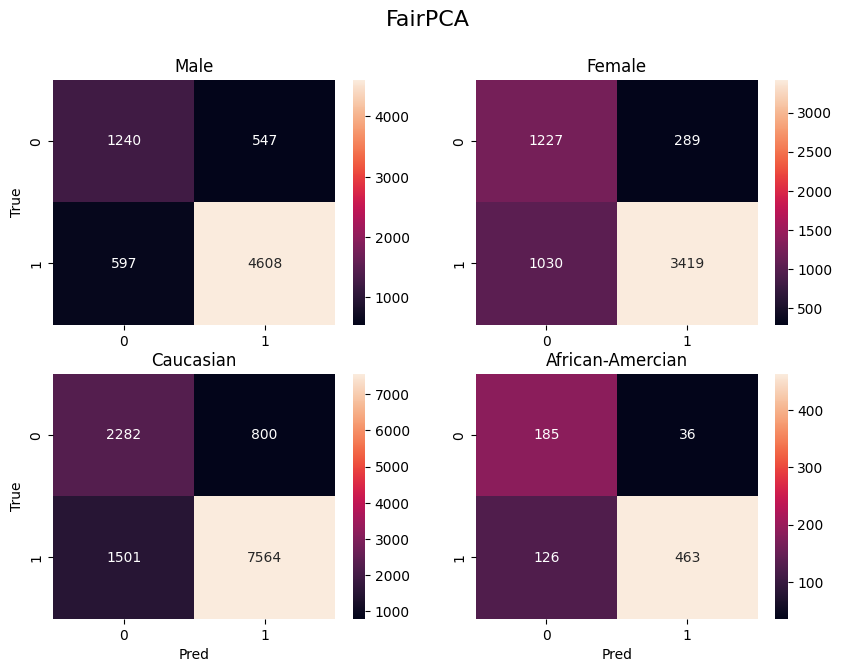

In [128]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(10,7))
# Set a title for the entire figure
fig.suptitle("FairPCA", fontsize=16)
g1= sns.heatmap(confusion_matrix_dict["Males"], annot=True, fmt='g', ax=ax1[0])
g1.set_ylabel("True")
g1.set_title("Male")
g2= sns.heatmap(confusion_matrix_dict["Females"], annot=True, fmt='g', ax=ax1[1])
#g1.set_xlabel("True")
g2.set_title("Female")
g3= sns.heatmap(confusion_matrix_dict["Whites"], annot=True, fmt='g', ax=ax2[0])
g3.set_ylabel("True")
g3.set_xlabel("Pred")
g3.set_title("Caucasian")
g4= sns.heatmap(confusion_matrix_dict["African-Americans"], annot=True, fmt='g', ax=ax2[1])
g4.set_xlabel("Pred")
g4.set_title("African-Amercian")
plt.show()



In [129]:
groups_train
#groups_test[groups_test["SEX"] == 1].index.tolist()
#Xs_test_debiased.shape

,SEX,RAC1P
69171,1,1
86793,1,1
69409,2,1
58700,2,1
34860,2,1
...,...,...
45891,2,1
117952,1,1
42613,1,1
43567,1,1


In [130]:
Xs_test_debiased

array([[-1.27022590e+00,  2.96293513e-04,  8.05272986e-04, ...,
        -5.16909274e-02, -1.24859597e-01,  1.15721627e-01],
       [-1.52606549e+00, -1.49954458e+00,  5.49712901e-03, ...,
        -2.10023237e+00, -3.37752907e-01,  6.36886322e-01],
       [ 1.68714368e+00, -1.26776807e+00,  5.01665724e-03, ...,
         2.73871472e+00,  1.42489739e+00,  1.59148028e+00],
       ...,
       [-8.12408761e-01,  2.26666321e+00, -2.59262256e-03, ...,
         1.67344959e-02, -9.72696563e-02, -9.45091969e-02],
       [ 7.43682876e-01,  1.80465948e+00, -3.18087974e-03, ...,
         3.14149624e+00,  4.44800744e-01,  2.29053259e+00],
       [ 9.53155250e-01, -1.36586994e+00,  7.45256952e-03, ...,
         1.41056410e+00,  1.11425857e+00, -1.18695132e+00]])

In [131]:
Xs_train_debiased

array([[-7.35105680e-01, -2.26772102e-01,  7.01126175e-03, ...,
         6.97892382e-02,  7.15870524e-02, -7.52301671e-02],
       [-1.42738079e+00, -1.56263037e-01,  3.69927934e-03, ...,
         4.01388233e-01, -3.51668198e-01,  4.81521277e-02],
       [-7.06731448e-01,  2.23045049e+00,  5.29235709e-03, ...,
         1.21663016e-03,  8.46949423e-02,  3.37432925e-02],
       ...,
       [ 1.43787691e+00, -1.07194806e+00,  1.58206669e-03, ...,
        -1.26356389e-01,  3.23695421e-02,  2.08385582e-02],
       [ 3.01300103e+00,  4.69290817e-01,  4.08475345e-03, ...,
        -2.64546806e-01, -2.67302078e+00,  3.20090430e+00],
       [ 9.31477295e-01,  1.69724948e-03,  7.23509550e-04, ...,
        -2.16738868e-02, -4.92776561e-01, -8.63159937e-01]])

In [132]:
#Xs_train_debiased_new.iloc[groups_train[groups_test["SEX"] == 1].index.tolist()]
Xs_train_debiased_df
#for i in groups_test[groups_test["SEX"] == 1].index:
#    print(i)
#    Xs_test_debiased_new.loc[i]

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,SCHL_Grade 4,SCHL_Grade 5,SCHL_Grade 6,SCHL_Grade 7,SCHL_Grade 8,SCHL_Grade 9,SCHL_Kindergarten,SCHL_Master's degree,SCHL_No schooling completed,"SCHL_Nursery school, preschool"
69171,-0.735106,-0.226772,0.007011,0.001704,-0.056611,-0.197689,1.080024,-0.296534,0.593563,-1.068438,...,-0.238473,0.886946,0.266227,-0.140075,0.279541,-0.405055,-0.281605,0.069789,0.071587,-0.075230
86793,-1.427381,-0.156263,0.003699,-0.004864,-0.387332,-0.194188,1.591244,-0.555536,-0.523198,-0.017662,...,-0.129997,-1.944183,0.851469,-1.683313,1.042992,-0.378209,-0.381872,0.401388,-0.351668,0.048152
69409,-0.706731,2.230450,0.005292,0.006338,0.140696,-0.185250,-0.167895,0.450190,0.389656,-0.995219,...,0.086382,0.592399,-0.035823,-0.148595,0.204692,-0.414504,-0.119466,0.001217,0.084695,0.033743
58700,1.054644,-1.153161,0.000632,0.010800,-0.095359,-0.275827,0.646399,1.085233,0.096484,-0.849245,...,-0.508023,0.785947,0.060886,0.646703,0.671064,0.229074,0.349181,-0.885570,-0.010090,0.745098
34860,3.950649,0.612273,0.009051,0.014608,-0.000614,-0.276253,-0.839492,-0.134677,0.214838,0.712220,...,1.076582,0.859093,0.524035,-0.171702,-2.197096,-2.165690,3.972402,0.101080,-1.281098,1.484269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58488,-0.976724,-2.215823,0.002054,0.002533,-0.487252,-0.244572,-0.055633,0.517341,-1.211428,0.196972,...,-0.224306,0.865854,0.155980,-0.436004,1.030182,0.494435,0.122740,-0.504298,-0.028088,0.049986
45933,-0.305298,0.191880,0.001716,0.001481,-0.123125,0.972937,1.209804,-0.326877,1.283559,-0.716302,...,-0.424004,0.278245,0.189773,-0.113475,0.023314,0.218555,0.099868,-0.157299,-0.196717,0.097479
116213,1.437877,-1.071948,0.001582,0.012724,0.009991,-0.215197,0.954984,1.217021,0.158214,-1.712691,...,-0.100975,0.495809,0.104850,-0.171193,0.037907,-0.207131,-0.220269,-0.126356,0.032370,0.020839
26965,3.013001,0.469291,0.004085,0.004516,-0.195764,0.895142,-0.132636,-0.452632,-0.188037,0.289334,...,-0.267930,1.085380,-0.386952,0.446785,0.160964,0.405635,-3.393825,-0.264547,-2.673021,3.200904


In [133]:
for i in groups_test.index:
    if i in Xs_test_debiased_df.index:
        print(f"Index {i} exists in Xs_test_debiased_df")
    else:
        print(f"Index {i} does not exist in Xs_test_debiased_df")
#Xs_test_debiased_df

Index 72476 exists in Xs_test_debiased_df
Index 108056 exists in Xs_test_debiased_df
Index 128094 exists in Xs_test_debiased_df
Index 46044 exists in Xs_test_debiased_df
Index 42380 exists in Xs_test_debiased_df
Index 25524 exists in Xs_test_debiased_df
Index 57955 exists in Xs_test_debiased_df
Index 34572 exists in Xs_test_debiased_df
Index 119330 exists in Xs_test_debiased_df
Index 89443 exists in Xs_test_debiased_df
Index 98260 exists in Xs_test_debiased_df
Index 6278 exists in Xs_test_debiased_df
Index 93345 exists in Xs_test_debiased_df
Index 101143 exists in Xs_test_debiased_df
Index 45420 exists in Xs_test_debiased_df
Index 63262 exists in Xs_test_debiased_df
Index 113121 exists in Xs_test_debiased_df
Index 122363 exists in Xs_test_debiased_df
Index 98961 exists in Xs_test_debiased_df
Index 33129 exists in Xs_test_debiased_df
Index 80737 exists in Xs_test_debiased_df
Index 36186 exists in Xs_test_debiased_df
Index 105823 exists in Xs_test_debiased_df
Index 46661 exists in Xs_tes

In [134]:
### score when split the dataset 
### Look at different scores
import matplotlib.pyplot as plt
clf.fit(Xs_train_debiased_df, y_train[:20000])

y_hat = model.predict(Xs_test_debiased)


score_dict_sex = {}
score_dict_race = {}
score_list = ["accuracy", "f1", "matthews_corrcoef"]
for i in range(1,3):
    score_dict_sex[i] = {}
    score_dict_race[i] = {}
    for score in score_list:
        # Filter rows in Xs_test_debiased_df based on SEX value from groups_test
        Xs_sex_filtered = Xs_test_debiased_df[groups_test["SEX"] == i]
        y_sex_filtered = y_test.loc[groups_test["SEX"] == i]

        # Filter rows in Xs_test_debiased_df based on RAC1P value from groups_test
        Xs_race_filtered = Xs_test_debiased_df[groups_test["RAC1P"] == i]
        y_race_filtered = y_test.loc[groups_test["RAC1P"] == i]

        # Perform cross-validation and calculate scores
        score_sex = cross_val_score(clf, Xs_sex_filtered, y_sex_filtered, cv=cv, scoring=score)
        score_race = cross_val_score(clf, Xs_race_filtered, y_race_filtered, cv=cv, scoring=score)

        # Store scores in dictionaries
        score_dict_sex[i][score] = score_sex
        score_dict_race[i][score] = score_race


print(score_dict_sex)
print(score_dict_race)        

        


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

{1: {'accuracy': array([0.72857143, 0.87142857, 0.81428571, 0.85714286, 0.82857143,
       0.82857143, 0.77142857, 0.8       , 0.74285714, 0.82857143,
       0.85714286, 0.74285714, 0.67142857, 0.84285714, 0.81428571,
       0.77142857, 0.8       , 0.84285714, 0.75714286, 0.81428571,
       0.8       , 0.87142857, 0.84285714, 0.85714286, 0.85714286,
       0.81428571, 0.8       , 0.81428571, 0.74285714, 0.74285714,
       0.8       , 0.82857143, 0.75714286, 0.8       , 0.78571429,
       0.77142857, 0.62857143, 0.78571429, 0.75714286, 0.82857143,
       0.82857143, 0.78571429, 0.68571429, 0.8       , 0.84285714,
       0.81428571, 0.77142857, 0.82857143, 0.82857143, 0.77142857,
       0.72857143, 0.81428571, 0.87142857, 0.84285714, 0.77142857,
       0.81428571, 0.78571429, 0.85714286, 0.8       , 0.85714286,
       0.78571429, 0.78571429, 0.75714286, 0.8       , 0.77142857,
       0.8       , 0.78571429, 0.77142857, 0.74285714, 0.72857143,
       0.9       , 0.72857143, 0.84285714, 0.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

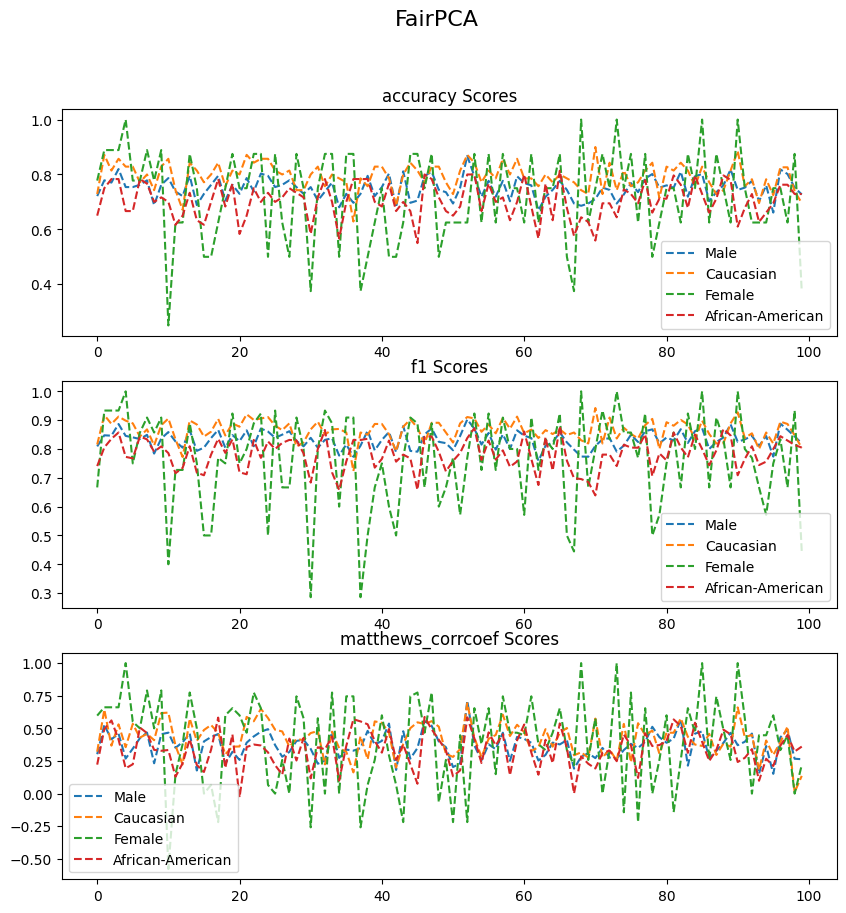

In [135]:

f, axes = plt.subplots(3,1, figsize=(10,10))
# Set a title for the entire figure
f.suptitle("FairPCA", fontsize=16)
for count, metric in enumerate(score_list):
    for i in range(1,3):
        if i == 1: 
            axes[count].plot(score_dict_race[i][metric], linestyle = "--", label = "Male")
            axes[count].plot(score_dict_sex[i][metric], linestyle = "--", label = "Caucasian")
            
        else: 
            axes[count].plot(score_dict_race[i][metric], linestyle = "--", label = "Female")
            axes[count].plot(score_dict_sex[i][metric], linestyle = "--", label = "African-American")
        
        axes[count].set_title(f"{metric} Scores")
        axes[count].legend()
        
        
        
        
        #plt.legend()

#plt.title("FairPCA")
plt.show()


        #plt.title(f"{} Scores")
